In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy
import scipy.fft as fft
import astropy.constants as const
import astropy.units as u
from astropy.io import fits
from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel
from astropy.cosmology import LambdaCDM
from photutils.segmentation import detect_threshold
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceCatalog
from scipy.interpolate import interp2d
from scipy.optimize import curve_fit
from math import pi
import math
import csv

In [2]:
#-----Loading data
cat = ascii.read('bullet_435.cat')

#-----Morphological Properties
xcen = cat['X_IMAGE'].data     # max(xcen): 7011.474, min(xcen): 311.515
ycen = cat['Y_IMAGE'].data     # max(ycen): 4638.641, min(ycen): 311.515
phi = cat['THETA_IMAGE'].data

xmin = cat['XMIN_IMAGE'].data
xmax = cat['XMAX_IMAGE'].data  
ymin = cat['YMIN_IMAGE'].data  # rms = fits.open('bullet_f435w_RMS.fits'), rms[0].shape : (5100, 7013)
ymax = cat['YMAX_IMAGE'].data  # min(xmin): 264, max(xmax): 7013, min(ymin):311, max(ymax):4643
                                       
a = cat['A_IMAGE'].data        # Profile RMS along major axis 라는데 확실히 맞는지는 모르겠다.
b = cat['B_IMAGE'].data 

#-----Make image               ##### !!I have a question!! ##### 이미지는 catalog로부터 못 만드는 것 같은데 그럼 이미지는 어떻게 만드나? drz_sci랑 RMS 모두 정상적으로 안나오는데..?
image = np.zeros((5100,7013))

#-----gamma, gamma1, gamma2
r = (a-b) / (a+b)
r1 = r * np.cos(2*phi)
r2 = r * np.sin(2*phi)
#r_cos_phi = r * np.cos(phi)
#r_sin_phi = r * np.sin(phi)

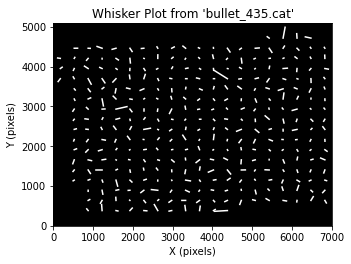

In [45]:
#-----Whisker Plot

r1_mean_list = np.array([])
r2_mean_list = np.array([])

length_r = np.array([])

loc_start = np.empty((0,2))
loc_end = np.empty((0,2))

dim2_array_r1 = np.zeros((20,20))   # 여기서 바로 mass map 그리는데 필요한 2차원 상의 gamma값 그려보려고 추가함.
dim2_array_r2 = np.zeros((20,20))   

for i in range(20):
    for j in range(20):
        ind = np.where( (255*i<ycen) & (ycen<255*(i+1)) & (350*j<xcen) & (xcen<350*(j+1)) )         # 20by20 각 셀의 indexing
        # 현재 cat의 number는 4474개

        r1_mean = 1e3*np.mean(r1[ind])                                                              # 각 셀에서의 gamma1과 gamma2의 평균(대표로 쓸 값)
        r2_mean = 1e3*np.mean(r2[ind])
        r1_mean_list = np.append(r1_mean_list, r1_mean)
        r2_mean_list = np.append(r2_mean_list, r2_mean)

        center = np.array([350*j+350/2, 255*i+255/2], dtype='float64').reshape(1,2)                 # 20by20의 각 셀의 중심 좌표
        loc_start = np.append(loc_start, center, axis=0)
        
        stick_end = np.array([center[0][0]+r1_mean, center[0][1]+r2_mean]).reshape(1,2)
        loc_end = np.append(loc_end, stick_end, axis=0)                                             # 20by20의 각 셀에 해당하는 whisker plot의 끝 점 좌표

        dim2_array_r1[i][j] += r1_mean/1e3                           # 여기서 바로 mass map 그리는데 필요한 2차원 상의 gamma값 그려보려고 추가함.
        dim2_array_r2[i][j] += r2_mean/1e3


ind = np.where(np.isnan(dim2_array_r1))
dim2_array_r1[ind]=0

ind2 = np.where(np.isnan(dim2_array_r2))
dim2_array_r2[ind]=0

background = np.zeros((5100,7013))                                   # 행이 y뜻함

fig = plt.figure(figsize=(5,5))
plt.imshow(background, cmap='gray', origin = 'lower')
plt.plot([loc_start[:,0],loc_end[:,0]], [loc_start[:,1],loc_end[:,1]], color='w')
plt.title("Whisker Plot from 'bullet_435.cat'")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.show()


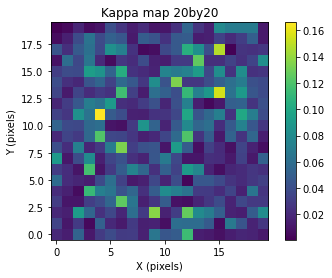

In [50]:
# 20by20으로 kappa map 그린 버전


#-----mass distribution map(=kappa map)

R1_fft = fft.fft2(dim2_array_r1)

R2_fft = fft.fft2(dim2_array_r2)

k1 = fft.fftfreq(R1_fft.shape[1], d=350)
k2 = fft.fftfreq(R2_fft.shape[0], d=255)


#####k = ( k1**2 + k2**2 )**(1/2) #이것도 놓쳤네.. meshgrid 써야만한다. 라인바이라인으로 점검 꼼꼼히 하면서 넘어가자.
K1, K2 = np.meshgrid(k1,k2)

#####K = ( K1**2 + K2**2 )**(1/2) #Kappa_fft 구할때 작은 수 곱해주는 것이 아니라 여기서 작은 수 '더해주는 것'이다.
K = ( K1**2 + K2**2 )**(1/2) + 1e-7

# print(r1_fft.shape[0]==len(x)) ### 주의! array의 인덱스는 행과 열 순서이므로 x,y 순이 아니다. y,x 순이다!
# print(r1_fft.shape[1]==len(y)) ### 주의! array의 인덱스는 행과 열 순서이므로 x,y 순이 아니다. y,x 순이다!

Kappa_fft = K**(-2) * ( (K1**2-K2**2)*R1_fft + 2*K1*K2*R2_fft )
Kappa = fft.ifft2(Kappa_fft)
Kappa_power = np.abs(Kappa)

fig = plt.imshow(Kappa_power, origin='lower')
plt.title("Kappa map 20by20")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(fig)
plt.show()



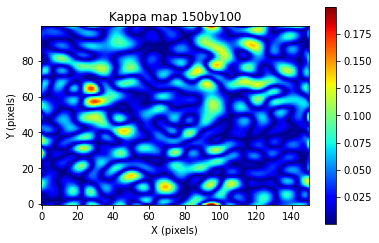

In [51]:
#-----mass distribution map(=kapp map)


R1_intep = interp2d(np.linspace(0,7012,20), np.linspace(0,5099,20), dim2_array_r1, kind='cubic')
R2_intep = interp2d(np.linspace(0,7012,20), np.linspace(0,5099,20), dim2_array_r2, kind='cubic')

# R1_intep = interp2d(loc_start[:,0], loc_start[:,1], r1_mean_list, kind='cubic')
# R2_intep = interp2d(loc_start[:,0], loc_start[:,1], r2_mean_list, kind='cubic')

x = np.linspace(0,7012,150)
y = np.linspace(0,5099,100)

R1_new = R1_intep(x,y)                  ### 이제부터 2차원 배열은 대문자로 
R2_new = R2_intep(x,y)

R1_fft = fft.fft2(R1_new)
R2_fft = fft.fft2(R2_new)

k1 = fft.fftfreq(R1_fft.shape[1], d=1)
k2 = fft.fftfreq(R2_fft.shape[0], d=1)

#####k = ( k1**2 + k2**2 )**(1/2) #이것도 놓쳤네.. meshgrid 써야만한다. 라인바이라인으로 점검 꼼꼼히 하면서 넘어가자.
K1, K2 = np.meshgrid(k1,k2)

#####K = ( K1**2 + K2**2 )**(1/2) #Kappa_fft 구할때 작은 수 곱해주는 것이 아니라 여기서 작은 수 '더해주는 것'이다.
K = ( K1**2 + K2**2 )**(1/2) + 1e-5

# print(r1_fft.shape[0]==len(x)) ### 주의! array의 인덱스는 행과 열 순서이므로 x,y 순이 아니다. y,x 순이다!
# print(r1_fft.shape[1]==len(y)) ### 주의! array의 인덱스는 행과 열 순서이므로 x,y 순이 아니다. y,x 순이다!

Kappa_fft = K**(-2) * ( (K1**2-K2**2)*R1_fft + 2*K1*K2*R2_fft )

Kappa = fft.ifft2(Kappa_fft)

Kappa_power = np.abs(Kappa)

fig = plt.imshow(Kappa_power, cmap='jet', origin='lower')
plt.title("Kappa map 150by100")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(fig)
plt.show()



[-0.013440359175006494, 0.005643287455506194, 0.017333534424260787, -7.207653502655955e-05, -0.011696890323960337, -0.005240413091245495, -0.022411171011475776, 0.004276310851733315, -0.004046267340574748, 0.006068722055173046, -0.005527017781607171, -0.0027243813651237443, -0.004044880741953531, -0.002465008834204339]
[0.030884976719770075, 0.025173180204316623, 0.02310101595380492, 0.018774185835516946, 0.012616991138780094, 0.012503222062316794, 0.013578681449233684, 0.012226783498884586, 0.01113865901282594, 0.011078716375969683, 0.01060811031954287, 0.00955035736498709, 0.010755812730443296, 0.010233388827255325]


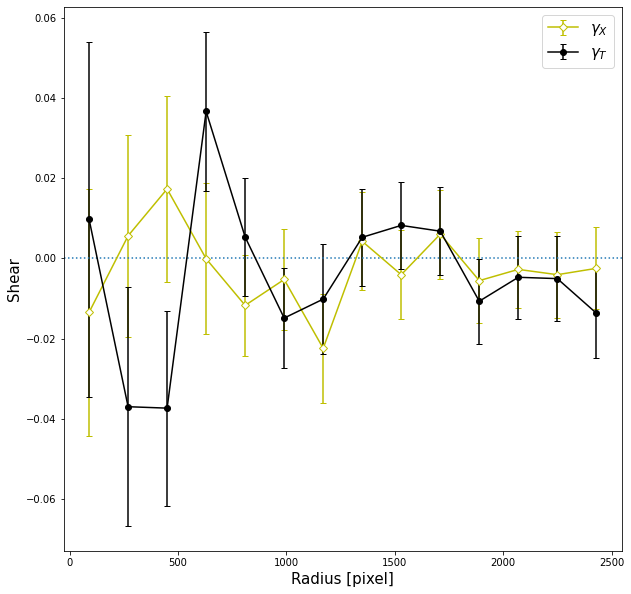

In [53]:
#----- Tangential Shear
origin = [3506, 2550]
dx = xcen - origin[0]
dy = ycen - origin[1]

# Ellipticity Rotation
radius = np.sqrt(dx**2 + dy**2)
cos_phi = dx/radius
sin_phi = dy/radius
cos_2phi = cos_phi**2 - sin_phi**2
sin_2phi = 2*cos_phi*sin_phi
r_t = -r1*cos_2phi - r2*sin_2phi ###### 효선이는 여기서 잘못했다.
r_x = -r1*sin_2phi + r2*cos_2phi ###### phi가 아니라 2phi로부터 정의된 real_e1, real_e2(53,54행 참고)를 써야하는게 자명하다. e1과 e2의 정의에 의해서.

# Binning
gamma_t = []
gamma_terr = []
gamma_x = []
gamma_xerr = []

for i in range(14):
    ind = np.where((radius>=i*180) & (radius<(i+1)*180))
    r_t_avg = np.mean(r_t[ind])
    r_t_std = np.std(r_t[ind]) / np.sqrt(len(r_t[ind]))
    r_x_avg = np.mean(r_x[ind])
    r_x_std = np.std(r_x[ind]) / np.sqrt(len(r_x[ind]))#####효선이 실수했다. r_x로 해야되는데 r_t로 했다.
    gamma_t.append(r_t_avg)
    gamma_terr.append(r_t_std)
    gamma_x.append(r_x_avg)
    gamma_xerr.append(r_x_std)
print(gamma_x)    
print(gamma_xerr)    

R = np.arange(90, 2550, 180)
fig = plt.figure(figsize=(10,10))
plt.errorbar(R, gamma_x, yerr=gamma_xerr, c='y', marker='D', mfc='w', capsize=3, label=r'$\gamma_X$')
plt.errorbar(R, gamma_t, yerr=gamma_terr, c='k', marker='o', capsize=3, label =r'$\gamma_T$')
plt.axhline(0, linestyle=':')
plt.legend(fontsize=15)
plt.xlabel("Radius [pixel]", size=15)
plt.ylabel("Shear", size=15)
plt.show()



In [64]:
#----- SIS fitting
def SIS(x, r_E): 
    result = copy.deepcopy(x)
    inner = np.where(x<=r_E)
    outer = np.where(x>r_E)
    result[inner] = (2*x[inner]-r_E)/r_E #####pdf에 나온 것은 [r_E]단위이므로 분자분모에 [pixel]/[r_E]를 곱해준 것이다.
    result[outer] = r_E/(2*x[outer]-r_E) # result는 reduced shear를 나타낸다.
    return result

pix_scale = 0.05    #[arcsec/pixel]

popt, pcov = curve_fit(SIS, R, gamma_t, sigma=gamma_terr, p0=(100))
#####r_E = popt[1] * pix_scale #####효선이가 틀린 것 같다. r_E는 [1]을 써야지 [0]은 x잖아..
#####r_Eerr = np.sqrt(pcov[1][1]) * pix_scale #####같은 이유로 이것도 [0]이 아니라 [1][1]일텐데.. [0]은 [x의 분산, x와 E_r의 공분산]이잖아..
#####게다가 error는 pcov에 sqrt를 취해야 하는데 효선이는 그냥 분산을 적었다. 이건 공식문서의 pcov 설명란에 "standard deviation error"를 구하는 방법이라고 정확히 명시되어있다.
#####위의 내 추측이 맞다는 정확적 증거로, 효선이는 그 다음에 r_Eerr을 활용하지 않았다. 오직 print로만 활용함.
##### !!!!! 내가 틀렸다. 이건 이상하게 popt가 값이 2개가 아니라 1개가 나와서 matrix가 2x2가 아니라 1x1이다... 그래서 popt랑 pcov 둘 다 효선이가 맞다. 
##### 단 np.sqrt()해줘야하는 건 내가 맞다.
##### !!!!! 아~ 이해했다.. def에서 첫 번째 들어가는 값은 xdata이고, curve_fit으로 추정하는 값은 그 다음에 위치하는 *params이다. 
r_E = popt[0] * pix_scale
r_Eerr = np.sqrt(pcov[0][0]) * pix_scale
##### 이건 효선이가 틀린게 맞다. r_Eerr은 내가 바로 윗줄에 적은 것 처럼, np.sqrt(pcov[0])이다.
##### 또 pcov는 2d array이므로 1x1이라도 인덱스를 두 개([0][0]) 써주어야 한다.

print("r_E = " + str(r_E) + "[arcsec]")
print("r_E_error = " + str(r_Eerr) + "[arcsec]")

r_E = 6.013932005987887[arcsec]
r_E_error = 0.9299481827544636[arcsec]


[0.2189781  0.65693431]
[0.2189781  0.65693431]
[0.2189781  0.65693431]
[0.2189781 0.6569343]
[0.2189781  0.65693431]
[0.28432911 0.85298734]
[0.28432911 0.85298733]
[0.28432911 0.85298734]
[0.3507278]
[0.3507278]
[0.3507278]
[ -0.73002582  -2.19007747  -3.65012912  -5.11018077  -6.57023241
  -8.03028406  -9.49033571 -10.95038736 -12.410439   -13.87049065
 -15.3305423  -16.79059395 -18.25064559 -19.71069724]
[0.39220504]
[0.39220503]
[0.39220504]
[0.51336969]
[0.51336968]
[0.51336969]
[0.72410763]
[0.72410762]
[0.72410763]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
c = 248408.0
c_err = 1933159841101.0
M_200 = 0.0[M⊙]
M_200_err = 1.4319222818347613e+47[M⊙]
r_s = 0.02[Mpc]
r_serr = 200046.848[Mpc]
[0.01481445 0.05261428 0.09041411 0.12821394 0.16601377 0.2038136
 0.24161343 0.27941326 0.31721309 0.35501292 0.39281275 0.43061258
 0.46841241 0.50621224 0.54401207 0.5818119  0.61961173 0.65741156
 0.69521139 0.73301122 0.77081105 0.80861088 0.84641071 0.88421054
 0.92201037 0.9598102  0.9

/var/folders/42/grbryvqx3vndy45_5d7lxyqr0000gn/T/ipykernel_78054/3003678588.py:34: RuntimeWarning: invalid value encountered in log
  delta_c = (200/3) * (c**3/(np.log(1+c)-c/(1+c)))
/var/folders/42/grbryvqx3vndy45_5d7lxyqr0000gn/T/ipykernel_78054/3003678588.py:10: RuntimeWarning: invalid value encountered in sqrt
  result[inner] = 1/(x_in**2-1) * (1-2*np.arctanh(np.sqrt((1-x_in)/(1+x_in)))/np.sqrt(1-x_in**2))
/var/folders/42/grbryvqx3vndy45_5d7lxyqr0000gn/T/ipykernel_78054/3003678588.py:10: RuntimeWarning: invalid value encountered in arctanh
  result[inner] = 1/(x_in**2-1) * (1-2*np.arctanh(np.sqrt((1-x_in)/(1+x_in)))/np.sqrt(1-x_in**2))
/var/folders/42/grbryvqx3vndy45_5d7lxyqr0000gn/T/ipykernel_78054/3003678588.py:26: RuntimeWarning: invalid value encountered in sqrt
  result[inner] = 4*np.arctanh(np.sqrt((1-x_in)/(1+x_in)))/(x_in**2*np.sqrt(1-x_in**2)) + 2*np.log(x_in/2)/x_in**2 - 1/(x_in**2-1) + 2*np.arctanh(np.sqrt((1-x_in)/(1+x_in)))/((x_in**2-1)*np.sqrt(1-x_in**2))
/var/folders

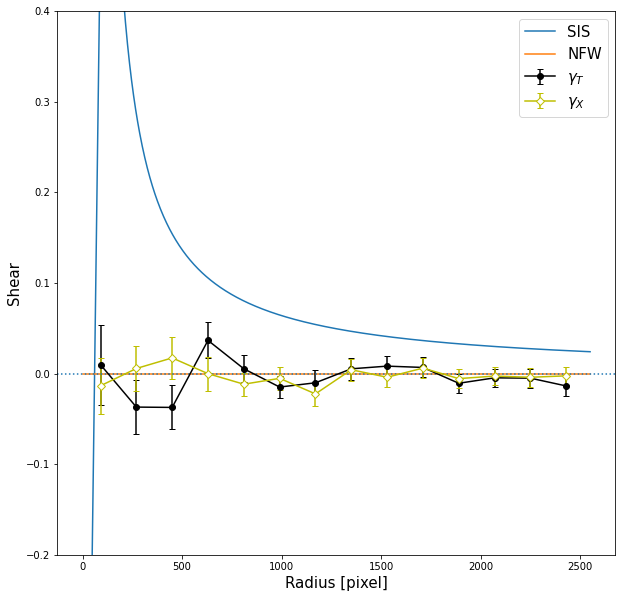

In [70]:
#----- NFW fitting
def f(r, r_s):
    x = r/r_s #####이렇게 해줌으로써 위의 SIS 때와는 다르게 함수 집어넣을 때 SIS(x,r_E/pix_scale)이렇게 할 필요 없이 NFW(x,popt[0],popt[1])<<효선이코드 255행>> 이렇게 바로 Einstein radius를 집어넣어줄 수 있게 된다.
    result = copy.deepcopy(x)
    inner = np.where(x<1)
    critical = np.where(x==1)
    outer = np.where(x>1)
    x_in = x[inner]
    x_out = x[outer]
    result[inner] = 1/(x_in**2-1) * (1-2*np.arctanh(np.sqrt((1-x_in)/(1+x_in)))/np.sqrt(1-x_in**2))
    result[critical] = 1/3
    result[outer] = 1/(x_out**2-1) * (1-2*np.arctan(np.sqrt((x_out-1)/(1+x_out)))/np.sqrt(x_out**2-1))
    return result

def j(r, r_s):
    x = r/r_s
    result = copy.deepcopy(x)
    inner = np.where(x<1)
    critical = np.where(x==1)
    outer = np.where(x>1)
    x_in = x[inner]
    x_out = x[outer]
    result[inner] = 4*np.arctanh(np.sqrt((1-x_in)/(1+x_in)))/(x_in**2*np.sqrt(1-x_in**2)) + 2*np.log(x_in/2)/x_in**2 - 1/(x_in**2-1) + 2*np.arctanh(np.sqrt((1-x_in)/(1+x_in)))/((x_in**2-1)*np.sqrt(1-x_in**2))
    result[critical] = 2*np.log(1/2)+5/3
    result[outer] = 4*np.arctan(np.sqrt((x_out-1)/(1+x_out)))/(x_out**2*np.sqrt(x_out**2-1)) + 2*np.log(x_out/2)/x_out**2 - 1/(x_out**2-1) + 2*np.arctan(np.sqrt((x_out-1)/(1+x_out)))/(x_out**2-1)**(3/2)
    #####내꺼 어딘가 타이포가 난 것 같다.
    #####[inner]와 [outer] 각각 첫째항의 분모에, 2뒤에 np.sqrt 안 붙여줘서 결과 잘못나온 것.
    return result

def NFW(r, r_s, c):
    delta_c = (200/3) * (c**3/(np.log(1+c)-c/(1+c)))
    Kk = (2*r_s*delta_c*rho_c)/smass_c
    K = Kk*f(r, r_s)
    Gamma = Kk*j(r, r_s)
    g = Gamma/(1-K) #####이거 효선이는 이것의 역수로 해서 잘못된 결과가 나왔다.
    ind = np.where(abs(g)>1)
    g[ind] = 1/g[ind]
    return g

Omegam, OmegaL = 0.3, 0.7
zl = 0.5
zs = 1.0

G = const.G.value ##### 위의 gamma도 똑같은 G로 썼는데, flow 따라가보니 상관없긴해도 중복되니 위의 것을 Gamma로 바꿨다.
v_c = const.c.value
Mpc_to_m = const.pc.value * 1e6
m_to_pc = const.pc.value ** -1
arcsec_to_rad = 1/3600 * np.pi/180
H0 = ( 73 * ( (u.km/u.s) / (1e6*u.pc) ) ).decompose().value #####나는 astropy.units을 활용했다.
H = np.sqrt(H0**2 * (Omegam*(1+zl)**3 + OmegaL)) #####이건 lens의 z를 써야한다.

cosmo = LambdaCDM(H0=73, Om0=Omegam, Ode0=OmegaL)

Dd = cosmo.angular_diameter_distance(zl).value * Mpc_to_m
Ds = cosmo.angular_diameter_distance(zs).value * Mpc_to_m
Xl = cosmo.comoving_distance(zl).value * Mpc_to_m
Xs = cosmo.comoving_distance(zs).value * Mpc_to_m
Dds = (Xs-Xl) / (1+zs) ##### Angular diameter distance로 구한 lens와 source 사이의 거리이다.
D = Dd*Ds/Dds ##### 이건 Time delay 파트에서 쓰이는고, 여기서는 안쓰여서 정의해 줄 필요 없었다.

rho_c = 3*H**2/ (8*pi*G)
smass_c = v_c**2 / (4*pi*G) * Ds/(Dd*Dds)

popt, pcov = curve_fit(NFW, R, gamma_t, sigma=gamma_terr, p0=(411,2.5e7))

r_s = popt[0] * pix_scale * arcsec_to_rad * Dd ##### Angular Daimeter Distance의 정의에 의해.
r_serr = np.sqrt(pcov[0][0]) * pix_scale * arcsec_to_rad * Dd ##### 위에서 196행과 같이 np.sqrt를 해주어야한다.
c = popt[1]
c_err = np.sqrt(pcov[1][1]) ##### 위와 마찬가지로 분산이므로 sqrt 취해야한다.
r_200 = c*r_s
r_200_err = r_s*c_err + c*r_serr ##### ??? error가 이런식으로 전파되나?? ---> 궁금한 지점에 적은 것 참고. 맞는 것 같다.

M_200 = 4*pi/3 * r_200**3 * 200 * rho_c / (2*10**30)
M_200_err = 4*pi/3 * r_200_err**3 * 200 * rho_c / (2*10**30)

print("c = " + str(round(c,0)))
print("c_err = " + str(round(c_err,0)))
print("M_200 = " + str(round(M_200,-30)) + "[M\u2299]")
print("M_200_err = " + str(round(M_200_err, -30)) + "[M\u2299]")
print("r_s = " + str(round(r_s * m_to_pc / 1e6, 3)) + "[Mpc]")
print("r_serr = " + str(round(r_serr * m_to_pc / 1e6,3)) + "[Mpc]")

x = np.linspace(1,2550,1000)
fig = plt.figure(figsize=(10,10))
plt.plot(x,SIS(x,r_E/pix_scale), label="SIS")
plt.plot(x,NFW(x,popt[0],popt[1]), label="NFW")
plt.errorbar(R, gamma_t, yerr=gamma_terr, c='k', marker='o', capsize=3, label=r'$\gamma_T$')
plt.errorbar(R, gamma_x, yerr=gamma_xerr, c='y', marker='D', mfc='w', capsize=3, label=r'$\gamma_X$') ##### 1123 pdf 끝부분보면 교수님은 gamma_X의 error값도 넣주셨는데 효선이는 넣지 않아서 내가 임의로 넣었다.
plt.ylim(-0.2,0.4)#plt.ylim(-0.15,0.15) #####범위 교수님과 같게 하였다.
plt.axhline(0, linestyle=':')
plt.legend(fontsize=15)
plt.xlabel("Radius [pixel]", size=15)
plt.ylabel("Shear", size=15)
plt.show()

# 드디어 끝. 2022_0205_02:32(AM).
# 인줄 알았는데 228행에서 언급한 것처럼 타이포나서 고침
# 진짜 끝. 2022_0205_03:08(AM).